In [1]:
# https://www.kaggle.com/haqishen/train-efficientnet-b0-w-36-tiles-256-lb0-87

In [2]:
import os
import sys

In [3]:
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm

In [4]:
DEBUG=False
data_dir = '../data'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
image_folder = os.path.join(data_dir, 'masks')

In [5]:
df_train.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [6]:
df_train.shape

(10616, 4)

In [7]:
from tqdm import tqdm_notebook as tqdm

In [8]:
image_mask_present = []
img_masks = os.listdir(image_folder)
for img in tqdm(img_masks):
    img = img.split('.')[0].split('_')[0]
    if img not in image_mask_present:
        image_mask_present.append(img)

In [9]:
len(image_mask_present)

10516

In [10]:
image_mask_present

['c0fccd51fdd784f9f0d708682293ed14',
 '698b4103a9f029886d32065d2ff436cc',
 '194066dc552ca10537a8aa68fbf1f65b',
 'da4b2e029abb2741bcfef60fa7ab10b0',
 '0960b0d7aa0b3c3cb95acb72e8bcf4e1',
 'db4f4e9261cf53d2fa74e15514d95680',
 '340517b590a8d20a3c8a13c8d3df4099',
 '095fc465913010fb51c3499000813454',
 '54e704b4854f66b42a6accec834e530c',
 'e6cccbed431da8be9c7590655e5a71a7',
 'bbb2cb27e4dde35199f7bf86bd845018',
 '0c6c14ee4d822472a576f1f6650d79f0',
 'c54f0e85e9e4d397843314eed507d06f',
 'd84c84c7e96c8a3609150e6afc1f1186',
 '2a6c1b639b5a5d0f32b60d8874f517b6',
 'aebe292567e0f8447fdc94994189a80a',
 '8f0014b11255b876c86bc3962d82a99e',
 '0e347f2fd5526d221233e35dacb2f79c',
 'b24d10450d164e8d0ec568628e8c95d6',
 '9d631d064fda13e2c2641d8ee30d9a2b',
 '5edc82d679cc29b4d7720bdc45c1ad45',
 'fcb820c8c3ea34338e648444b90b8307',
 '560e4f17e8b93958846f1186eb720f76',
 'ac8682bef4c6309210b50279feff0a83',
 '7fd7f2b3b421239d1874a2feaf76af8b',
 '0bc4086b7c5ed0463dde3926f10fc298',
 'f3d92b6ae8a2ad0325d714b395229e79',
 

In [11]:
df_train = df_train.loc[df_train.image_id.isin(image_mask_present)]

In [12]:
df_train.shape

(10516, 4)

In [13]:
df_train.reset_index(inplace=True)

In [14]:


kernel_type = '1a'
kernel_type_base = 'how_to_train_effnet_b0_to_get_LB_0.86'
enet_type = 'efficientnet-b0'
fold = 0
tile_size = 256
image_size = 256
n_tiles = 36
batch_size = 2
num_workers = 4
out_dim = 5
init_lr = 3e-4
warmup_factor = 10

warmup_epo = 1
n_epochs = 1 if DEBUG else 30
df_train = df_train.sample(100).reset_index(drop=True) if DEBUG else df_train

device = torch.device('cuda')

print(image_folder)

../data/masks


In [15]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

,index,image_id,data_provider,isup_grade,gleason_score,fold
0,0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,3
1,1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,4
2,2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,0
3,3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,1
4,4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,2


In [16]:
pretrained_model = {
    'efficientnet-b0': '/home/watts/.torch/models/efficientnet-b0-08094119.pth'
}

In [17]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(pretrained_model[backbone]))

        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [18]:
def get_tiles(img, mode=0):
        result = []
        h, w, c = img.shape
        pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
        pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

        img2 = np.pad(img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values=255)
        img3 = img2.reshape(
            img2.shape[0] // tile_size,
            tile_size,
            img2.shape[1] // tile_size,
            tile_size,
            3
        )

        img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        if len(img3) < n_tiles:
            img3 = np.pad(img3,[[0,n_tiles-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
        idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:n_tiles]
        img3 = img3[idxs]
        for i in range(len(img3)):
            result.append({'img':img3[i], 'idx':i})
        return result, n_tiles_with_info >= n_tiles


In [19]:
class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        all_images = []
#         tiff_file = os.path.join(image_folder, f'{img_id}_mask.tiff')
#         print(tiff_file)
        for ii in range(self.n_tiles):
            png_file = os.path.join(image_folder, f'{img_id}_{ii}.png')
            img = cv2.imread(png_file)
            all_images.append(img)
#         image = np.array(all_images)
#         print(image.shape)
#         image = skimage.io.MultiImage(tiff_file)[1]
#         tiles, OK = get_tiles(image, self.tile_mode)

        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))
            
        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(all_images) > idxes[i]:
#                     this_img = tiles[idxes[i]]['img']
                    this_img = all_images[idxes[i]]
#                     print(this_img.shape)
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img

        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)

        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)

In [20]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])
transforms_val = albumentations.Compose([])

In [21]:
# tiff_file = "../data/train_images/984505f6a79b889bed5897d2135b85b1.tiff"
# image = skimage.io.MultiImage(tiff_file)[1]
# tiles, OK = get_tiles(image, 0)

In [22]:
# image.shape

In [23]:
# image[-1]

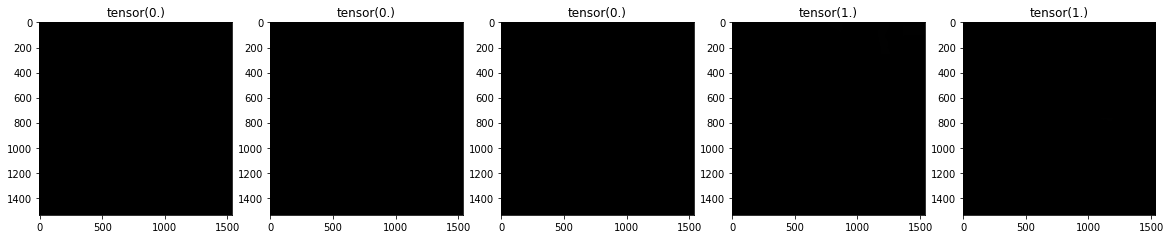

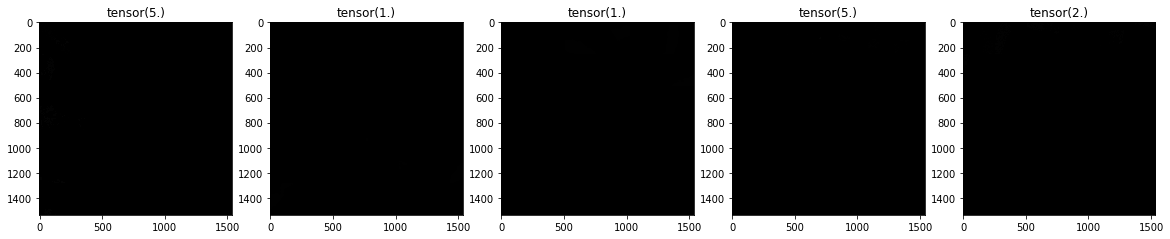

In [24]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))

In [25]:
criterion = nn.BCEWithLogitsLoss()

In [26]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss

In [27]:
def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
    qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

In [28]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)

# model = enetv2(enet_type, out_dim=out_dim)
# model = model.to(device)

model_path = '/home/watts/Kaggle/kpanda/cache/how_to_train_effnet_b0_to_get_LB_0.86_best_fold0.pth'
model = enetv2(enet_type, out_dim=out_dim)
model.load_state_dict(torch.load(model_path), strict=True)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid))

8410 2106


In [29]:
qwk_max = 0.
best_file = f'../cache/{kernel_type}_best_fold{fold}.pth'
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)
    with open(f'log_{kernel_type}.txt', 'a') as appender:
        appender.write(content + '\n')

    if qwk > qwk_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        torch.save(model.state_dict(), best_file)
        qwk_max = qwk

torch.save(model.state_dict(), os.path.join(f'../cache/{kernel_type}_final_fold{fold}.pth'))

Fri Jun 19 23:42:19 2020 Epoch: 1


/home/watts/anaconda3/envs/panda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



qwk 0.5388542358542023 qwk_k 0.248900705593619 qwk_r 0.680307748437415
Sat Jun 20 00:22:53 2020 Epoch 1, lr: 0.0000300, train loss: 0.42366, val loss: 0.51233, acc: 18.04368, qwk: 0.53885
score2 (0.000000 --> 0.538854).  Saving model ...
Sat Jun 20 00:22:53 2020 Epoch: 2



qwk -0.07402327495417271 qwk_k -0.05808823529411744 qwk_r 0.03679733233540938
Sat Jun 20 01:03:50 2020 Epoch 2, lr: 0.0003000, train loss: 0.29238, val loss: 1.40684, acc: 12.53561, qwk: -0.07402
Sat Jun 20 01:03:50 2020 Epoch: 3



qwk 0.7554964489369866 qwk_k 0.6313432835820896 qwk_r 0.8466788195683341
Sat Jun 20 01:44:49 2020 Epoch 3, lr: 0.0000300, train loss: 0.21811, val loss: 0.51176, acc: 42.83001, qwk: 0.75550
score2 (0.538854 --> 0.755496).  Saving model ...
Sat Jun 20 01:44:49 2020 Epoch: 4



qwk 0.004720072671632103 qwk_k 0.0 qwk_r 0.004933265476991799
Sat Jun 20 02:25:47 2020 Epoch 4, lr: 0.0002965, train loss: 0.22769, val loss: 132.88342, acc: 24.88129, qwk: 0.00472
Sat Jun 20 02:25:47 2020 Epoch: 5



qwk 0.11781084982081047 qwk_k 0.08582257621532552 qwk_r 0.054825250451214
Sat Jun 20 03:06:43 2020 Epoch 5, lr: 0.0002921, train loss: 0.21145, val loss: 729.13721, acc: 11.44349, qwk: 0.11781
Sat Jun 20 03:06:43 2020 Epoch: 6



qwk 0.21285224545399806 qwk_k -0.013617583870434435 qwk_r 0.2597278449490944
Sat Jun 20 03:47:40 2020 Epoch 6, lr: 0.0002861, train loss: 0.20703, val loss: 0.73023, acc: 24.97626, qwk: 0.21285
Sat Jun 20 03:47:40 2020 Epoch: 7



qwk 0.06561121512630841 qwk_k 0.05721018824108115 qwk_r 0.022835299198633585
Sat Jun 20 04:28:38 2020 Epoch 7, lr: 0.0002785, train loss: 0.19813, val loss: 32.87829, acc: 12.53561, qwk: 0.06561
Sat Jun 20 04:28:38 2020 Epoch: 8



qwk -0.08660321727926545 qwk_k -0.07984014541289519 qwk_r -0.021743343544827987
Sat Jun 20 05:09:37 2020 Epoch 8, lr: 0.0002694, train loss: 0.19481, val loss: 15.51274, acc: 11.77588, qwk: -0.08660
Sat Jun 20 05:09:37 2020 Epoch: 9



qwk 0.02135278550513431 qwk_k 0.0 qwk_r 0.04635263049534655
Sat Jun 20 05:50:32 2020 Epoch 9, lr: 0.0002589, train loss: 0.19095, val loss: 4.59773, acc: 13.77018, qwk: 0.02135
Sat Jun 20 05:50:32 2020 Epoch: 10



qwk 0.1933479004166231 qwk_k 0.0 qwk_r 0.3162661538008652
Sat Jun 20 06:31:30 2020 Epoch 10, lr: 0.0002471, train loss: 0.18613, val loss: 4.19828, acc: 12.86800, qwk: 0.19335
Sat Jun 20 06:31:30 2020 Epoch: 11



qwk 0.6011581861486968 qwk_k 0.0 qwk_r 0.623872631466436
Sat Jun 20 07:12:27 2020 Epoch 11, lr: 0.0002342, train loss: 0.18555, val loss: 3.87737, acc: 28.49003, qwk: 0.60116
Sat Jun 20 07:12:27 2020 Epoch: 12



qwk 0.38601842959523847 qwk_k 0.0 qwk_r 0.46439679421483826
Sat Jun 20 07:53:24 2020 Epoch 12, lr: 0.0002203, train loss: 0.18468, val loss: 0.59874, acc: 27.44539, qwk: 0.38602
Sat Jun 20 07:53:24 2020 Epoch: 13



qwk 0.0 qwk_k 0.0 qwk_r 0.0
Sat Jun 20 08:34:23 2020 Epoch 13, lr: 0.0002055, train loss: 0.18402, val loss: 1.40157, acc: 11.68091, qwk: 0.00000
Sat Jun 20 08:34:23 2020 Epoch: 14



qwk 0.2966119922028535 qwk_k 0.1604350781781101 qwk_r 0.4220009507060588
Sat Jun 20 09:15:19 2020 Epoch 14, lr: 0.0001901, train loss: 0.18079, val loss: 0.49449, acc: 15.85945, qwk: 0.29661
Sat Jun 20 09:15:19 2020 Epoch: 15



qwk 0.33756950955997556 qwk_k 0.4071469086783892 qwk_r 0.1085584690167174
Sat Jun 20 09:56:16 2020 Epoch 15, lr: 0.0001743, train loss: 0.17793, val loss: 10.61199, acc: 13.53276, qwk: 0.33757
Sat Jun 20 09:56:16 2020 Epoch: 16



qwk 0.7930596752831858 qwk_k 0.4880499728408473 qwk_r 0.8916834148365731
Sat Jun 20 10:37:13 2020 Epoch 16, lr: 0.0001581, train loss: 0.17661, val loss: 0.33195, acc: 38.41406, qwk: 0.79306
score2 (0.755496 --> 0.793060).  Saving model ...
Sat Jun 20 10:37:13 2020 Epoch: 17



qwk 0.2443709547094054 qwk_k -0.04130892038205558 qwk_r 0.48270606272204986
Sat Jun 20 11:18:09 2020 Epoch 17, lr: 0.0001419, train loss: 0.17637, val loss: 1.46884, acc: 17.28395, qwk: 0.24437
Sat Jun 20 11:18:09 2020 Epoch: 18



qwk 0.0761151994121202 qwk_k -0.0005253480430784663 qwk_r 0.19830316084961286
Sat Jun 20 11:59:07 2020 Epoch 18, lr: 0.0001257, train loss: 0.17431, val loss: 4.49555, acc: 20.84520, qwk: 0.07612
Sat Jun 20 11:59:07 2020 Epoch: 19



qwk 0.15567111396408195 qwk_k 0.01765768802254475 qwk_r 0.4607985915057513
Sat Jun 20 12:40:06 2020 Epoch 19, lr: 0.0001099, train loss: 0.17282, val loss: 1.59540, acc: 23.17189, qwk: 0.15567
Sat Jun 20 12:40:06 2020 Epoch: 20



qwk 0.277659722905263 qwk_k 0.11904201020808791 qwk_r 0.28336498231686147
Sat Jun 20 13:21:06 2020 Epoch 20, lr: 0.0000945, train loss: 0.17173, val loss: 3.33239, acc: 13.58025, qwk: 0.27766
Sat Jun 20 13:21:06 2020 Epoch: 21



qwk 0.6183067785058174 qwk_k 0.5009908667930381 qwk_r 0.5386594072385631
Sat Jun 20 14:02:08 2020 Epoch 21, lr: 0.0000797, train loss: 0.16971, val loss: 2.79299, acc: 20.56030, qwk: 0.61831
Sat Jun 20 14:02:08 2020 Epoch: 22



qwk 0.31392022836417854 qwk_k 0.0027978549778502337 qwk_r 0.3886324450098765
Sat Jun 20 14:43:09 2020 Epoch 22, lr: 0.0000658, train loss: 0.16837, val loss: 2.43953, acc: 12.01330, qwk: 0.31392
Sat Jun 20 14:43:09 2020 Epoch: 23



qwk 0.09698217107168361 qwk_k 0.056971108283014105 qwk_r 0.2181022810783233
Sat Jun 20 15:24:10 2020 Epoch 23, lr: 0.0000529, train loss: 0.16750, val loss: 2.94090, acc: 22.12726, qwk: 0.09698
Sat Jun 20 15:24:10 2020 Epoch: 24



qwk 0.8661506437066977 qwk_k 0.7296929654100272 qwk_r 0.9274764170867872
Sat Jun 20 16:05:11 2020 Epoch 24, lr: 0.0000411, train loss: 0.16700, val loss: 0.24219, acc: 56.74264, qwk: 0.86615
score2 (0.793060 --> 0.866151).  Saving model ...
Sat Jun 20 16:05:11 2020 Epoch: 25



qwk 0.6398757803699977 qwk_k 0.5228083518951123 qwk_r 0.6041425148775021
Sat Jun 20 16:46:16 2020 Epoch 25, lr: 0.0000306, train loss: 0.16498, val loss: 1.77658, acc: 17.52137, qwk: 0.63988
Sat Jun 20 16:46:16 2020 Epoch: 26



qwk 0.8594852096621641 qwk_k 0.7324379714821436 qwk_r 0.8989076681935821
Sat Jun 20 17:27:19 2020 Epoch 26, lr: 0.0000215, train loss: 0.16358, val loss: 0.24088, acc: 58.11966, qwk: 0.85949
Sat Jun 20 17:27:19 2020 Epoch: 27



qwk 0.8395176998231775 qwk_k 0.714645942705965 qwk_r 0.8767592665846425
Sat Jun 20 18:08:23 2020 Epoch 27, lr: 0.0000139, train loss: 0.16357, val loss: 0.27201, acc: 50.71225, qwk: 0.83952
Sat Jun 20 18:08:23 2020 Epoch: 28



qwk 0.7315155200179102 qwk_k 0.6300554693643339 qwk_r 0.7261781036473891
Sat Jun 20 18:49:29 2020 Epoch 28, lr: 0.0000079, train loss: 0.16404, val loss: 0.45885, acc: 35.94492, qwk: 0.73152
Sat Jun 20 18:49:29 2020 Epoch: 29



qwk 0.8594411685204281 qwk_k 0.7336563801751254 qwk_r 0.8994369938306517
Sat Jun 20 19:30:22 2020 Epoch 29, lr: 0.0000035, train loss: 0.16301, val loss: 0.23638, acc: 57.45489, qwk: 0.85944
Sat Jun 20 19:30:22 2020 Epoch: 30



qwk 0.8679396633658223 qwk_k 0.7440808014317157 qwk_r 0.9117496659683618
Sat Jun 20 20:11:16 2020 Epoch 30, lr: 0.0000009, train loss: 0.16332, val loss: 0.23647, acc: 60.06648, qwk: 0.86794
score2 (0.866151 --> 0.867940).  Saving model ...
